<a href="https://colab.research.google.com/github/kingyeet9048/final_dsci_project/blob/master/Camshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection/Tracking In A Video Using Meanshift and Camshift

## Content

- Introduction to video processing (object tracking) with Meanshift and Camshift
- Background
- Example

## Introduction

### What is video processing?

Video processing is a specific type of signal processing that frequently uses video filters having the input and output signals as video streams or video files.

- DVDs
- Television sets
- Video players

### What is object tracking?

Defined as the process of locating the position of a moving object or multiple objects over time using a camera. 

### Example applications of object tracking

- Security and surveillance 
- Video abstraction
- Retail space instrumentation
- Medical therapy
- Traffic management

### Meanshift

Mean-shift tracking, also known as the Kernel-Based tracking, is an **iterative positioning method built on the augmentation of a parallel measure**.

- Responsible for finding the center of the probability distribution of the object being tracked.
- An efficient approach to tracking objects whose appearance is defined by **histograms**.

Other example Mean-shift is used for:
- cluster analysis in computer vision
- image processing

### Camshift

CAMShift (Continuously Adaptive Mean Shift) algorithm is **a color-based object tracking method to deal with problems such as image noise, distractors, irregular object motions due to perspective, and lighting variations**.

- Derived from the mean-shift algorithm.
- Main difference: CAMShift adjusts to search for the window size. 

# Background

### But how does the actual method work? 
- Capture a frame of the video, establish a window around the object you want to track
- We make a color density histogram (array) of the area inside the window.
- Calculate the centroid of this histogram and keep track of its position on the video frame


### Now we loop the following for each frame in the window
- put the frame into a color density histogram
- find the area of the frame that resembles the same probability distribution of the window
- find the centroid of the new distribution
- see if it has moved, if yes, then move the tracking window's centroid to the new centroid

### Meanshift Example
- In the following picture, the first frame is being used to track the white car
- In the first frame, the histogram of the color density is being created within the blue window and then the centroid of this distribution will be used to find it in later frames
- As the video plays, the window is moving along the car because the color distribution of the white car is moving in each new frame
- Because this function is only using meanshift, the size of the window does not change

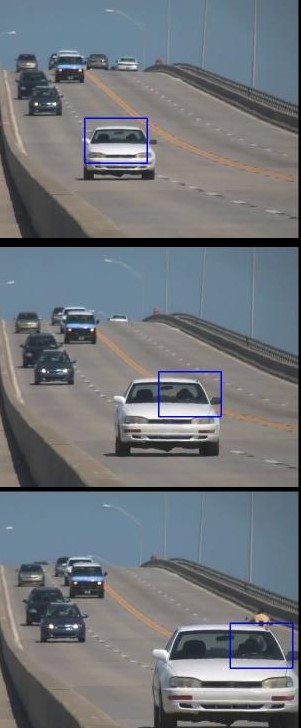

In [1]:
from IPython.core.display import Image 
Image('car_example.jpg')

### So then what is camshift?
- The difference between meanshift and camshift is that camshift is continuously updating the window size that is being used to track the object. 
    - Works better for tracking objects that are moving towards or away from the camera
- Once the window size has been changed in camshift, the rest of the algorithm works the same as meanshift. 
    - It just finds the highest density area in the frame and puts the centroid of the window on top of the centroid of the highest density spot.

### Camshift example
- Now, the window is being adjusted to fit the entire car as it is being tracked
- it is still being tracked by the center of the color distribution

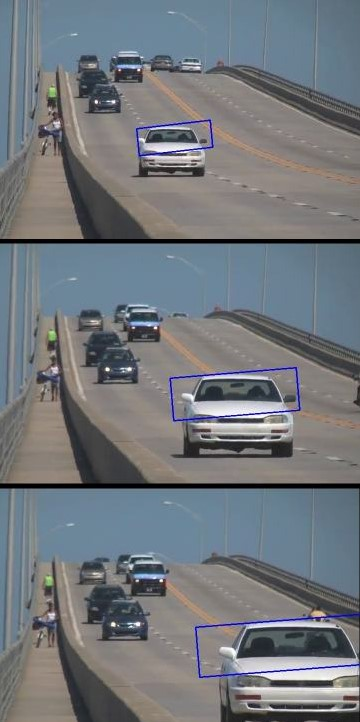

In [2]:
Image('car_example2.jpg')

# Examples

### Let's try a local example
https://www.pyimagesearch.com/wp-content/uploads/2014/11/opencv_crash_course_camshift.pdf

# Defining the functions we need...

In [5]:
# import the necessary packages
import numpy as np
import argparse
import cv2
# initialize the current frame of the video, along with the list of# ROI points along with whether or not this is input mode
frame = None
roiPts = []
inputMode = False

# Helps to select the region of interest.

In [2]:
def selectROI(event, x, y, flags, param):
  global frame, roiPts, inputMode

  if inputMode and event == cv2.EVENT_LBUTTONDOWN and len(roiPts) < 4:
    roiPts.append((x, y))
    cv2.circle(frame, (x, y), 4, (0, 255, 0), 2)
    cv2.imshow("frame", frame)

# Main will render the image, backproject, and draw the rectangle.

In [3]:

def main():
    camera = cv2.VideoCapture('videos/phone.MOV')
    global frame, roiPts, inputMode
    # setup the mouse callback
    cv2.namedWindow("frame")
    cv2.setMouseCallback("frame", selectROI)

    # initialize the termination criteria for cam shift, indicating
    # a maximum of ten iterations or movement by a least one pixel
    # along with the bounding box of the ROI
    termination = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
    roiBox = None

    # keep looping over the frames
    while True:
        # grab the current frame
        (grabbed, frame) = camera.read()

        # check to see if we have reached the end of the
        # video
        if not grabbed:
            break

        # if the see if the ROI has been computed
        if roiBox is not None:
            # convert the current frame to the HSV color space
            # and perform mean shift
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            backProj = cv2.calcBackProject([hsv], [0], roiHist, [0, 180], 1)

            # apply cam shift to the back projection, convert the
            # points to a bounding box, and then draw them
            (r, roiBox) = cv2.CamShift(backProj, roiBox, termination)
            pts = np.int0(cv2.boxPoints(r))
            cv2.polylines(frame, [pts], True, (0, 255, 0), 2)

        # show the frame and record if the user presses a key
        cv2.imshow("frame", frame)
        key = cv2.waitKey(1) & 0xFF

        # handle if the 'i' key is pressed, then go into ROI
        # selection mode
        if key == ord("a") and len(roiPts) < 4:
            # indicate that we are in input mode and clone the
            # frame
            inputMode = True
            orig = frame.copy()

            # keep looping until 4 reference ROI points have
            # been selected; press any key to exit ROI selction
            # mode once 4 points have been selected
            while len(roiPts) < 4:
                cv2.imshow("frame", frame)
                cv2.waitKey(0)

            # determine the top-left and bottom-right points
            roiPts = np.array(roiPts)
            print(roiPts)
            cv2.waitKey(0)
            s = roiPts.sum(axis = 1)
            tl = roiPts[np.argmin(s)]
            br = roiPts[np.argmax(s)]

            # grab the ROI for the bounding box and convert it
            # to the HSV color space
            roi = orig[tl[1]:br[1], tl[0]:br[0]]
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
            #roi = cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)

            # compute a HSV histogram for the ROI and store the
            # bounding box
            roiHist = cv2.calcHist([roi], [0], None, [16], [0, 180])
            roiHist = cv2.normalize(roiHist, roiHist, 0, 255, cv2.NORM_MINMAX)
            roiBox = (tl[0], tl[1], br[0], br[1])

        # if the 'q' key is pressed, stop the loop
        elif key == ord("q"):
            break

    # cleanup the camera and close any open windows
    camera.release()
    cv2.destroyAllWindows()


In [6]:
main()

[[775 471]
 [814 474]
 [804 567]
 [766 563]]


# loading in the video and recording the first frame

In [7]:
import cv2 as cv
cap  = cv.VideoCapture('videos/phone.MOV')
ret, frame = cap.read()

# Getting the roi's points

In [8]:
r, h, c, w = 640,40,800,20
track_window = (c, r, w, h)

# Getting the histogram of the roi.
Its goin to be used to backproject the frame

In [9]:
roi = frame[r:r+h, c:c+w]
hsv_roi = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, np.array((0.,60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv.calcHist([hsv_roi],[0,1],mask,[12, 12],[0,181, 0, 256])
#cv.normalize(roi_hist,roi_hist,0, 255,cv.NORM_MINMAX)


In [10]:
# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

# Reading each frame and updating the polylines as the ROI moves. 

In [11]:
while(1):
    ret ,frame = cap.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0, 1],roi_hist,[0,180, 0, 256],1)
        #clean up the noice
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
        dst = cv.filter2D(dst, -1, kernel)
        # apply camshift to get the new location
        ret, track_window = cv.CamShift(dst, track_window, term_crit)
        # Draw it on image
        pts = cv.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv.polylines(frame,[pts],True, (255, 0, 0),2)
        cv.imshow("img2", img2)
        k = cv.waitKey(60) & 0xff
        if k == 32:
            break
        else:
            cv.imwrite(chr(k)+".jpg",dst)
    else:
        break
cv.destroyAllWindows()
cap.release()

# References

- https://docs.opencv.org/3.4.2/db/df8/tutorial_py_meanshift.html
- https://medium.com/@claudio.vindimian/understanding-and-implementing-the-camshift-object-tracking-algorithm-python-81587c24eda8
- https://towardsdatascience.com/machine-learning-algorithms-part-13-mean-shift-clustering-example-in-python-4d6452720b00
- https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.695.4638&rep=rep1&type=pdf
